# Projet 7 : Implémentez un modèle de scoring


Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
 
 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Les données
Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

Votre mission : 
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Michaël, votre manager, vous incite à sélectionner un ou des kernels Kaggle pour vous faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring. Si vous le faites, vous devez analyser ce ou ces kernels et le ou les adapterpour vous assurer qu’ils répond(ent) aux besoins de votre mission.

# 

# Sommaire

## I. Importation
### A. Importation des bibliothèques

### B. Importation des fichiers



## II. Modélisation
### A. Préparation des données

### B. Entrainement des modèles
#### 1. Régression Logistique
#### 2. Dummy Classifier
#### 3. Random Forest
#### 4. XGBoost
#### 5. LightGBM

### C. Gestion du Déséquilibre
#### 1. RandomUnderSample
#### 2. RandomOverSample
#### 3. Smote


## III. Optimisation des modèles
### A. Optimisation de la Régression Logistique

### B. Optimisation du XGBOOST

### C. Optimisation du LightGBM

### D. Entrainement des modèles optimisés

### E. Enregistrement du modèle



## IV. Conclusion partie modélisation

# 

## I. Importation

### A. Importation des bibliothèques

In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import mlflow


# Métriques de classification
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix, auc, classification_report


# Modélisation : Régression Logistique
from sklearn.linear_model import LogisticRegression
# Modélisation : RandomForest
from sklearn.ensemble import RandomForestClassifier
# Modélisation : XGBoost
from sklearn.ensemble import GradientBoostingClassifier
# Modélisation LGBM
from lightgbm import LGBMClassifier




import warnings
warnings.filterwarnings('ignore')

# Feature Engineering
import re
from collections import Counter

# Preprocessing et standardisation


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Séparation du jeu de données
from sklearn.model_selection import train_test_split



# Modélisation
# Régression Logistique
from sklearn.linear_model import LogisticRegression

# Dummy Classifier
from sklearn.dummy import DummyClassifier

# XGBoost
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# Modélisation LGBM
from lightgbm import LGBMClassifier



# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter # counter takes values returns value_counts dictionary
from sklearn.datasets import make_classification

# Optimisation du modèle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)


# 

### B. Importation du fichier

In [2]:
# Importation de notre dataframe
df = pd.read_csv('df_modélisation.csv')

In [3]:
# Création d'un jeu de données pour l'étape du Dashboard
import random

# Sélection aléatoire de 100 clients
random_clients = random.sample(list(df['SK_ID_CURR']), k=100)

# Création du nouveau DataFrame df_dashboard avec les clients sélectionnés
df_dashboard = df[df['SK_ID_CURR'].isin(random_clients)].copy()
df_dashboard.to_csv('df_dash_KNN.csv', index =False)

# Suppression de la variable 'TARGET' dans le nouveau DataFrame
df_dashboard.drop('TARGET', axis=1, inplace=True)

# Enregistrement du DataFrame df_dashboard dans un fichier CSV
df_dashboard.to_csv('df_tabdashboard.csv', index=False)

# 

### A. Préparation des données

Nous allons procéder à la séparation du jeu de données du train.

Dans le cadre de notre standardisation, nous allons tester 2 possibilités :
- StandardScaler,
- MinMaxScaler.

L'objectif sera également de déterminer le meilleur résultat et de sélectionner le meilleur modèle avec la technique la plus cohérente.

##### Séparation des données

In [4]:
# Création du train_test_split

# Séparation des données de la cible
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Division en train et validation (75/25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=100)

display('Données entrainements : ',X_train.shape, X_val.shape)
display('Données de validation',y_train.shape, y_val.shape)

'Données entrainements : '

(230629, 162)

(76877, 162)

'Données de validation'

(230629,)

(76877,)

##### Création des jeux de données pour l'étape evidently

In [5]:
import pandas as pd

# Création des DataFrames pour les données d'entraînement et de validation
train_data = pd.DataFrame(X_train)
test_data = pd.DataFrame(X_val)


# Enregistrement des données d'entraînement dans un fichier CSV
train_data.to_csv('application_train.csv', index=False)

# Enregistrement des données de validation dans un fichier CSV
test_data.to_csv('application_test.csv', index=False)

print("Les fichiers 'application_train.csv' et 'application_test.csv' ont été créés avec succès.")

Les fichiers 'application_train.csv' et 'application_test.csv' ont été créés avec succès.


##### Utilisation du StandardScaler

In [6]:
# Créer un objet StandardScaler
scaler = StandardScaler()

# Adapter et transformer les données d'entraînement
X_train_stand = scaler.fit_transform(X_train)

# Transformer les données de test
X_val_stand = scaler.transform(X_val)

##### Utilisation du MinMaxScaler

In [7]:
# Créer un objet MinMaxScaler
scaler = MinMaxScaler()

# Adapter et transformer les données d'entraînement
X_train_scaled = scaler.fit_transform(X_train)

# Transformer les données de validation
X_val_scaled = scaler.transform(X_val)

Nous sommes dans le cadre d'une classification.

Afin de procéder à notre modélisation, nous allons utiliser plusieurs modèles de classification :

- Régression Logistique,
- Dummy Classifier
- Random Forest,
- XGBoost,
- LIGHTGBM.

#### F1 et F2 score

Le F1 score et le F2 score sont deux métriques de performance utilisées pour évaluer la précision d'un modèle de classification binaire, c'est-à-dire un modèle qui doit décider entre deux classes possibles (par exemple, vrai ou faux, positif ou négatif, maladie ou non maladie, etc.).

Le F1 score est une mesure de la précision globale du modèle, calculée comme la moyenne harmonique de la précision (la proportion de prédictions correctes parmi toutes les prédictions positives) et du rappel (la proportion de prédictions positives correctes parmi toutes les occurrences réelles de la classe positive). Il est défini comme suit :

F1 score = 2 * (precision * recall) / (precision + recall)

Le F2 score est similaire au F1 score, mais accorde une pondération plus importante à la précision qu'au rappel. En d'autres termes, il accorde plus d'importance aux vrais positifs qu'aux faux négatifs. Il est défini comme suit :

F2 score = (1 + beta^2) * (precision * recall) / (beta^2 * precision + recall)

où beta est un paramètre qui contrôle le poids relatif de la précision par rapport au rappel. Si beta est inférieur à 1, le F2 score accorde moins d'importance à la précision que le F1 score, tandis que si beta est supérieur à 1, il accorde plus d'importance à la précision.

En résumé, la principale différence entre le F1 score et le F2 score réside dans la pondération relative de la précision et du rappel. Le F1 score accorde une importance égale à la précision et au rappel, tandis que le F2 score permet de donner plus d'importance à la précision si nécessaire.

##### Création de la matrice pour analyse du déséquilibre

In [8]:
# Création de la fonction personnalisée

def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
    PPV = TP / (TP + FP)
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

def custom_metric_f2(y, y_pred):

    return fbeta_score(y, y_pred,2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True )
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True )

La première fonction custom_metric calcule l'indice de Fowlkes-Mallows (FMI) pour évaluer la similarité entre deux ensembles, dans ce cas, les ensembles d'étiquettes réelles et prédites. FMI est basé sur la précision positive (PPV) et le taux de vrais positifs (TPR). La PPV mesure le nombre de vrais positifs par rapport au nombre total de prédictions positives, tandis que le TPR mesure le nombre de vrais positifs par rapport au nombre total de positifs réels. La formule de FMI est la racine carrée de la PPV multipliée par le TPR.

La deuxième fonction custom_metric_f2 calcule la mesure F2. F2 est un exemple de la mesure F-beta avec une valeur de beta de 2,0. Il a pour effet de diminuer l'importance de la précision et d'augmenter l'importance du rappel. Si maximiser la précision minimise les faux positifs et maximiser le rappel minimise les faux négatifs, alors la mesure F2 accorde plus d'attention à la minimisation des faux négatifs qu'à la minimisation des faux positifs.

Enfin, les deux fonctions sont utilisées pour créer deux objets de score personnalisés, custom_scorer et custom_scorer_f2, à l'aide de la fonction make_scorer de scikit-learn. Ces objets de score peuvent ensuite être utilisés dans les fonctions d'entraînement et d'évaluation du modèle de classification binaire pour évaluer la performance de ce dernier.

##### Fonction pour utiliser les différentes métriques

In [9]:
def model_eval_score(model, Xval, yval):
    y_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, y_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, y_pred):.3}')
    print(f'precision score   : {precision_score(yval, y_pred):.3}')
    print(f'recall score      : {recall_score(yval, y_pred):.3}')
    print(f'F1 score          : {f1_score(yval, y_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, y_pred, beta=2):.2}')
    print(f'ROCAUC score      : {roc_auc_score(yval, y_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, y_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# 

### B. Entrainement du modèle

### 1. Régression Logistique

##### Création du MLFlow

In [10]:
# Création du MLFLOW

mlflow.set_experiment('Modélisation Projet7 ')

mlflow.sklearn.autolog()

[[70628   134]
 [ 5967   148]]
Accuracy score    : 0.921
precision score   : 0.525
recall score      : 0.0242
F1 score          : 0.0463
F2 score          : 0.03
ROCAUC score      : 0.511
custom metric FMI : 0.113



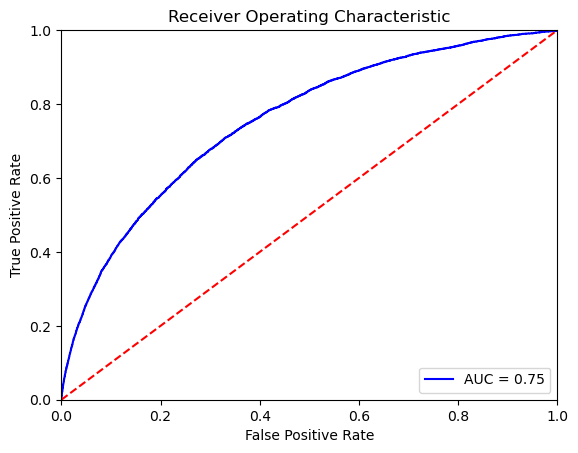

In [11]:
# Régression Logistique avec StandardScaler
logreg = LogisticRegression()


# Second run du mlflow
with mlflow.start_run(run_name = 'Reglog StandardScaler'):
    logreg = LogisticRegression()
    logreg.fit(X_train_stand, y_train)

# Prédiction sur l'ensemble de validation
y_pred = logreg.predict(X_val_stand)

model_eval(logreg, X_val_stand, y_val)

[[70657   105]
 [ 5987   128]]
Accuracy score    : 0.921
precision score   : 0.549
recall score      : 0.0209
F1 score          : 0.0403
F2 score          : 0.026
ROCAUC score      : 0.51
custom metric FMI : 0.107



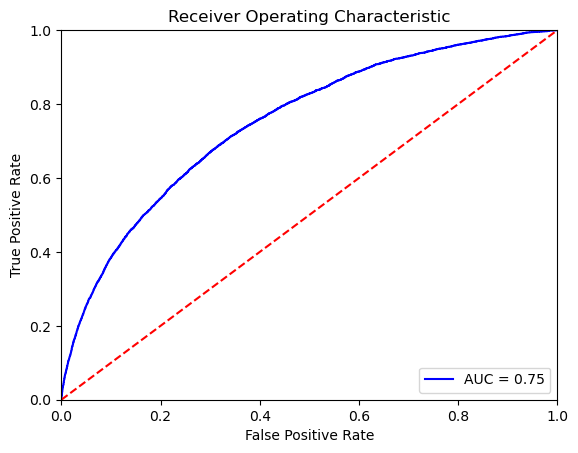

In [12]:
# Régression Logistique avec MinMaxScaler
logreg = LogisticRegression()

# 3ème run du mlflow
with mlflow.start_run(run_name = 'Reglog MinMaxScaler'):
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)


# Prédiction sur l'ensemble de validation
y_pred = logreg.predict(X_val_scaled)

model_eval(logreg, X_val_scaled, y_val)

Concernant la Régression Logistique, nous constatons que le déséquilibre est une problématique pour notre modélisation (ce qui sera également un soucis sur l'ensemble des modèles). Nous constatons que le modèle avec le StandardScaler présente le meilleur résultat.

### 2. Dummy Classifier

[[65106  5656]
 [ 5634   481]]
Accuracy score    : 0.853
precision score   : 0.0784
recall score      : 0.0787
F1 score          : 0.0785
F2 score          : 0.079
ROCAUC score      : 0.499
custom metric FMI : 0.0785



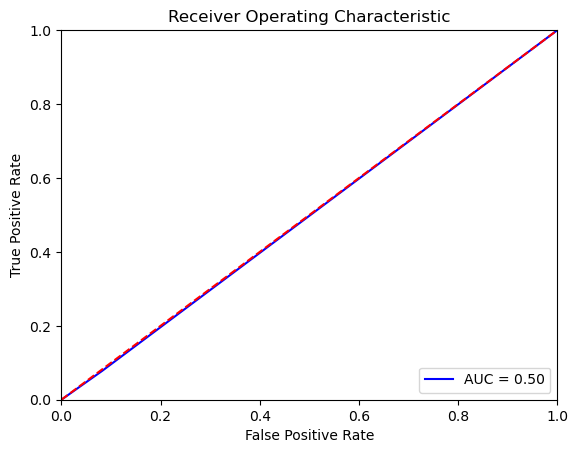

In [13]:
# DummyClassifier avec StandardScaler


# Instancier le DummyClassifier
with mlflow.start_run(run_name = 'Dummy StandardScaler'):
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train_stand, y_train)


# Prédire les étiquettes de classe pour les données de test
y_pred = dummy_clf.predict(X_val_stand)

model_eval(dummy_clf, X_val_stand, y_val)

[[65045  5717]
 [ 5633   482]]
Accuracy score    : 0.852
precision score   : 0.0778
recall score      : 0.0788
F1 score          : 0.0783
F2 score          : 0.079
ROCAUC score      : 0.499
custom metric FMI : 0.0783



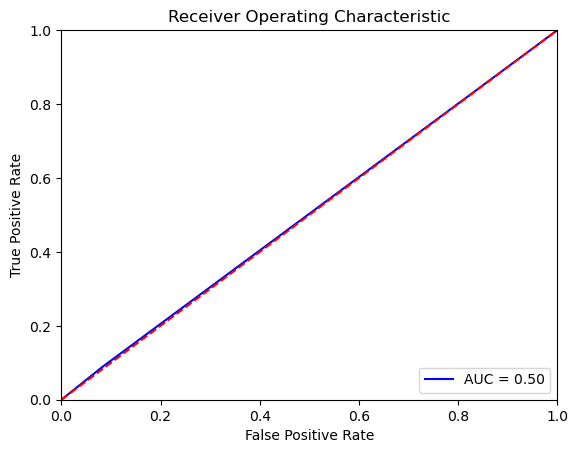

In [14]:
# DummyClassifier avec MinMaxScaler


# Instancier le DummyClassifier en utilisant la stratégie stratified
with mlflow.start_run(run_name = 'Dummy MinMaxScaler'):
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train_scaled, y_train)


# Prédire les étiquettes de classe pour les données de test
y_pred = dummy_clf.predict(X_val_scaled)

model_eval(dummy_clf, X_val_scaled, y_val)

Le modèle du Dummy Classifier a une meilleure capacité de traitement du déséquilibre. Toutefois, les différentes métriques démontrent la faiblesse de l'entrainement de ce dernier. De nouveau, le StandardScaler présente le meilleur résultat.

### 3. Random Forest

[[70754     8]
 [ 6108     7]]
Accuracy score    : 0.92
precision score   : 0.467
recall score      : 0.00114
F1 score          : 0.00228
F2 score          : 0.0014
ROCAUC score      : 0.501
custom metric FMI : 0.0231



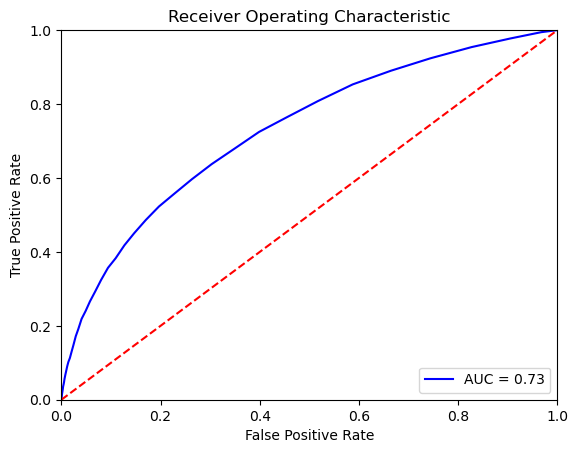

In [15]:
# RandomForest avec StandardScaler

randor = RandomForestClassifier()

# Second run du mlflow
with mlflow.start_run(run_name = 'Forest StandardScaler'):
    logreg = LogisticRegression()
    randor.fit(X_train_stand, y_train)


# Prédiction sur l'ensemble de validation
y_pred = randor.predict(X_val_stand)

model_eval(randor, X_val_stand, y_val)

[[70758     4]
 [ 6105    10]]
Accuracy score    : 0.921
precision score   : 0.714
recall score      : 0.00164
F1 score          : 0.00326
F2 score          : 0.002
ROCAUC score      : 0.501
custom metric FMI : 0.0342



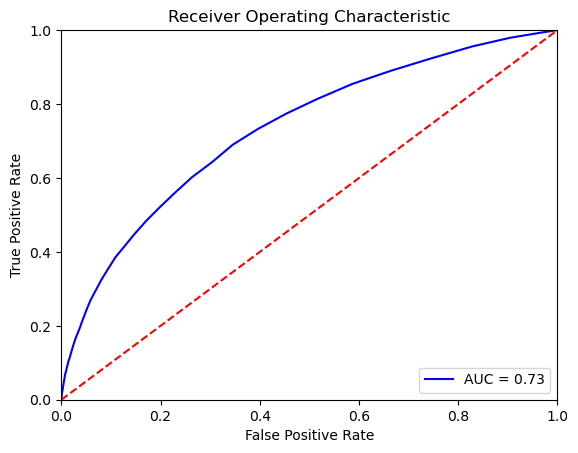

In [16]:
# RandomForest avec MinMaxScaler

randor = RandomForestClassifier()

# 3ème run du mlflow
with mlflow.start_run(run_name = 'Forest MinMaxScaler'):
    logreg = LogisticRegression()
    randor.fit(X_train_scaled, y_train)


# Prédiction sur l'ensemble de validation
y_pred = randor.predict(X_val_scaled)

model_eval(randor, X_val_scaled, y_val)

Le Random Forest présente de très mauvais résultats concernant le déséquilibre mais également sur les différentes métriques. De plus, ce modèle est long à entraîner, il sera utilisé pour tester le déséquilibre mais présente un faible attrait pour le développer.

### 4. XGBoost

[[70371   391]
 [ 5759   356]]
Accuracy score    : 0.92
precision score   : 0.477
recall score      : 0.0582
F1 score          : 0.104
F2 score          : 0.071
ROCAUC score      : 0.526
custom metric FMI : 0.167



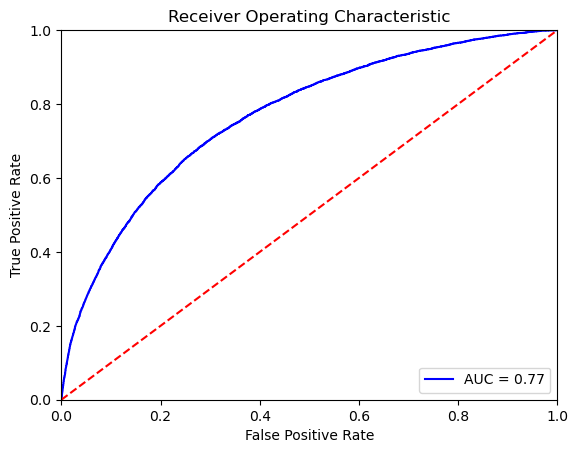

In [17]:
# XGBoost avec StandardScaler


# Création du modèle avec XGBoost
xgboost =xgb.XGBClassifier()

# Second run du mlflow
with mlflow.start_run(run_name = 'XGBoost StandardScaler'):
    xgboost =xgb.XGBClassifier()
    xgboost.fit(X_train_stand, y_train)


# Prédiction sur l'ensemble de validation
y_pred = xgboost.predict(X_val_stand)

model_eval(xgboost, X_val_stand, y_val)

[[70371   391]
 [ 5758   357]]
Accuracy score    : 0.92
precision score   : 0.477
recall score      : 0.0584
F1 score          : 0.104
F2 score          : 0.071
ROCAUC score      : 0.526
custom metric FMI : 0.167



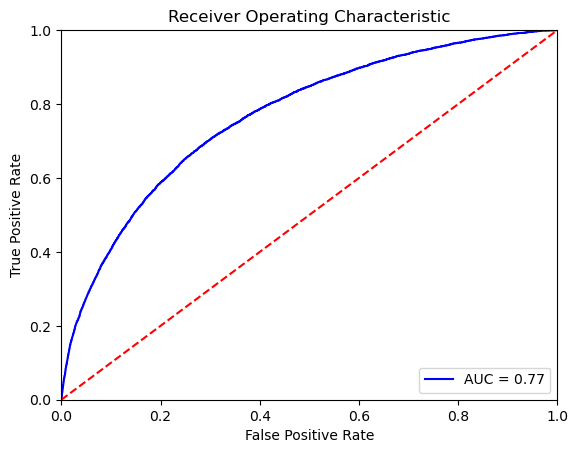

In [18]:
# XGBoost avec MinMaxScaler

# Création du modèle avec XGBoost
xgboost =xgb.XGBClassifier()

# 3ème run du mlflow
with mlflow.start_run(run_name = 'XGBoost MinMaxScaler'):
    xgboost =xgb.XGBClassifier()
    xgboost.fit(X_train_scaled, y_train)



# Prédiction sur l'ensemble de validation
y_pred = xgboost.predict(X_val_scaled)

model_eval(xgboost, X_val_scaled, y_val)

Ce modèle présente les meilleurs résultats concernant le déséquilibre mais également pour les métriques. Le StandardScaler et le MinMaxScaler sont similaires pour notre analyse.

### 5. LIGHTGBM

[[70586   176]
 [ 5878   237]]
Accuracy score    : 0.921
precision score   : 0.574
recall score      : 0.0388
F1 score          : 0.0726
F2 score          : 0.048
ROCAUC score      : 0.518
custom metric FMI : 0.149



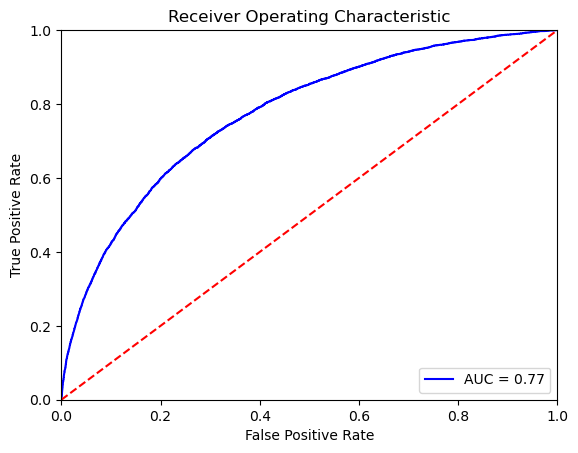

In [19]:
# LIGHTGBM avec StandardScaled

# Création de la pipeline
lightgbm = LGBMClassifier()

# 2nd run
with mlflow.start_run(run_name = 'LightGBM StandardScaler'):
    lightgbm = LGBMClassifier()
    lightgbm.fit(X_train_stand, y_train,
                eval_metric= custom_metric_f2, verbose= 200)



# Prédiction sur l'ensemble de validation
y_pred = lightgbm.predict(X_val_stand)

model_eval(lightgbm, X_val_stand, y_val)

[[70575   187]
 [ 5885   230]]
Accuracy score    : 0.921
precision score   : 0.552
recall score      : 0.0376
F1 score          : 0.0704
F2 score          : 0.046
ROCAUC score      : 0.517
custom metric FMI : 0.144



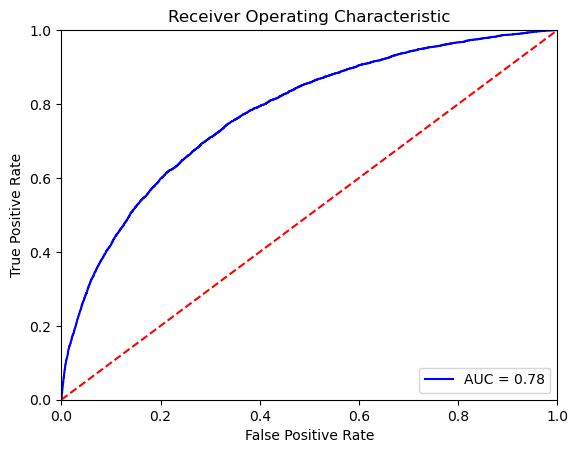

In [20]:
# LIGHTGBM avec MinMaxScaler

# Création de la pipeline
lightgbm = LGBMClassifier()

# 3nd run
with mlflow.start_run(run_name = 'LightGBM MinMaxScaler'):
    lightgbm = LGBMClassifier()
    lightgbm.fit(X_train_scaled, y_train,
                eval_metric= custom_metric_f2, verbose= 200)



# Prédiction sur l'ensemble de validation
y_pred = lightgbm.predict(X_val_scaled)

model_eval(lightgbm, X_val_scaled, y_val)

In [21]:
from pyngrok import ngrok

ngrok.kill()

autoken = '2OgoOfZZ3yCMB1e4IXBlXhNjEG9_2kgwhpFVFBXEr1kzkEnA2'
ngrok.set_auth_token(autoken)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

t=2023-06-09T18:15:49-0400 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=C:\\Users\\gregm\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\gregm\\.ngrok2\\ngrok.yml
t=2023-06-09T18:15:49-0400 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040


MLflow Tracking UI: https://6204-2a01-cb20-84e-5400-935-fc70-5813-aa7e.ngrok-free.app


Ce modèle présente de bons résultats pour les métriques mais un déséquilibre toujours important pour notre modélisation. 
Nous allons tester ce dernier avec le déséquilibre.

### Conclusion modélisation

Nous avons pu procéder à un test sur plusieurs modèles, ces derniers sont les plus utilisés dans le domaine de la classification. Nos constats sur la modélisation :

- l'accuracy présente un faible intérêt sur notre problématique (les différents modèles ont une accuracy très similaire).
- une utilisation de rééquilibrage des données est nécessaire pour la suite de notre projet,
- le rapport de classification, le F1 et F2 score, notre métrique personnalisée et le ROC-AUC nous ont permis d'avoir une première idée du projet.

A présent, nous allons procéder à l'utilisation des techniques de rééquilibrage.
Pour cela, le StandardScaler sera utilisé pour cette seconde phase.

# 

### C. Gestion du déséquilibre

Afin de tester la meilleure méthode, nous allons prendre la décision d'utiliser 3 techniques concernant le rééquilibrage des données :

SMOTE (Synthetic Minority Over-sampling Technique) est une technique de sur-échantillonnage qui consiste à créer des échantillons synthétiques pour les classes minoritaires en interpolant les points de données de la classe minoritaire. Elle est souvent utilisée pour résoudre les problèmes de déséquilibre de classe dans les jeux de données en augmentant le nombre d'échantillons de la classe minoritaire.

RANDOMOVERSAMPLE est une technique de sur-échantillonnage qui consiste à dupliquer des échantillons de la classe minoritaire de manière aléatoire pour atteindre un nombre égal ou proche du nombre d'échantillons de la classe majoritaire. Cette technique est simple et rapide à mettre en œuvre, mais peut entraîner un surapprentissage si elle est appliquée de manière excessive.

RANDOMUNDERSAMPLE est une technique de sous-échantillonnage qui consiste à supprimer aléatoirement des échantillons de la classe majoritaire pour atteindre un nombre égal ou proche du nombre d'échantillons de la classe minoritaire. Cette technique peut être efficace pour réduire le temps d'apprentissage et le coût de traitement, mais elle peut également entraîner une perte d'informations importantes et une baisse de la précision du modèle.

Il est important de noter que ces techniques sont souvent utilisées pour résoudre des problèmes de déséquilibre de classe dans les jeux de données. Cependant, il est également important de prendre en compte les avantages et les inconvénients de chaque technique, ainsi que leur impact sur les performances du modèle, avant de choisir une technique pour un jeu de données spécifique.

#### 1. RandomUnderSample

In [22]:
# Création des déséquilibres

under = RandomUnderSampler(random_state=100)

# fit and apply the transform
X_under, y_under = under.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 211920, 1: 18709})
Counter({0: 18709, 1: 18709})


#### Régression Logistique

2023/06/09 18:15:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c455645085fe40bca62dedc45bb7c22e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
t=2023-06-09T18:15:54-0400 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": context deadline exceeded"


[[49291 21471]
 [ 1958  4157]]
Accuracy score    : 0.695
precision score   : 0.162
recall score      : 0.68
F1 score          : 0.262
F2 score          : 0.41
ROCAUC score      : 0.688
custom metric FMI : 0.332



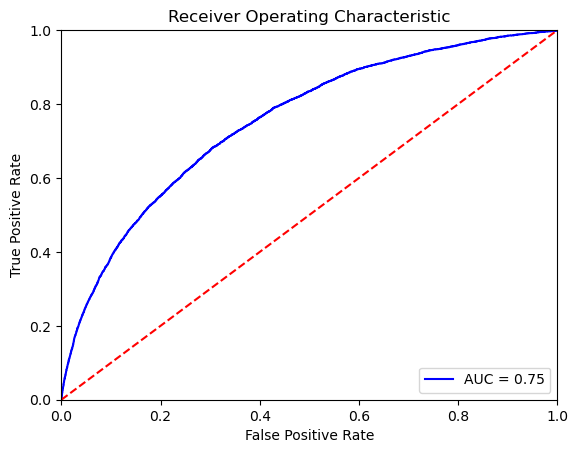

In [23]:

logis_under = LogisticRegression()
logis_under.fit(X_under, y_under)


log_under_rus = logis_under.predict(X_val_stand)


model_eval(logis_under, X_val_stand, y_val)

#### Dummy Classifier

2023/06/09 18:15:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '36aa3949e0a945b0a007d4e34d7d175a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35288 35474]
 [ 3059  3056]]
Accuracy score    : 0.499
precision score   : 0.0793
recall score      : 0.5
F1 score          : 0.137
F2 score          : 0.24
ROCAUC score      : 0.499
custom metric FMI : 0.199



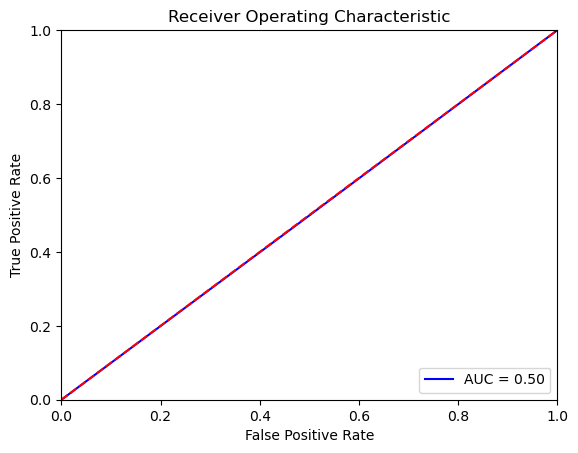

In [24]:
dummy_under = DummyClassifier(strategy="stratified")
dummy_under.fit(X_under, y_under)


dummy_under_rus = logis_under.predict(X_val_stand)

model_eval(dummy_under, X_val_stand, y_val)


#### Random Forest

2023/06/09 18:15:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db22b6ad21c347d4b3fb1b8fdc02cfa0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[49903 20859]
 [ 1988  4127]]
Accuracy score    : 0.703
precision score   : 0.165
recall score      : 0.675
F1 score          : 0.265
F2 score          : 0.42
ROCAUC score      : 0.69
custom metric FMI : 0.334



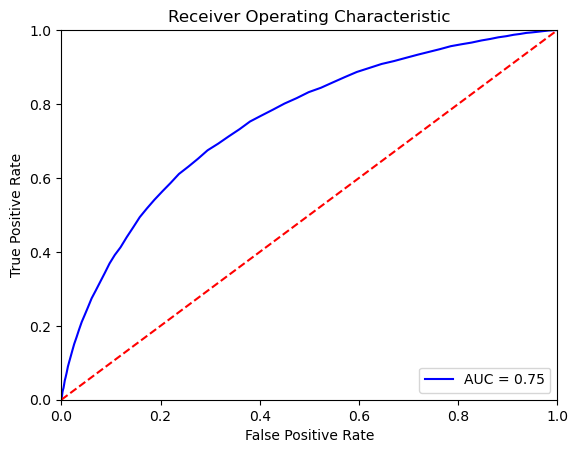

In [25]:
random_under = RandomForestClassifier()
random_under.fit(X_under, y_under)

random_under_rus = random_under.predict(X_val_stand)

model_eval(random_under, X_val_stand, y_val)

#### XGBoost

[[49338 21424]
 [ 1897  4218]]
Accuracy score    : 0.697
precision score   : 0.164
recall score      : 0.69
F1 score          : 0.266
F2 score          : 0.42
ROCAUC score      : 0.694
custom metric FMI : 0.337



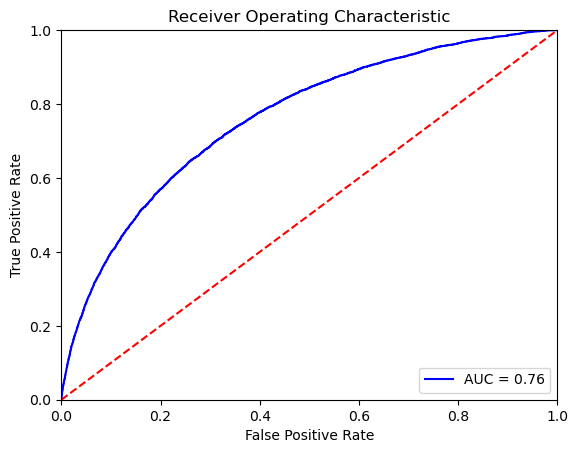

In [26]:
xgboost_under = xgb.XGBClassifier()
xgboost_under.fit(X_under, y_under)

xgboost_under_rus = xgboost_under.predict(X_val_stand)

model_eval(xgboost_under, X_val_stand, y_val)

#### LightGBM

[[50113 20649]
 [ 1884  4231]]
Accuracy score    : 0.707
precision score   : 0.17
recall score      : 0.692
F1 score          : 0.273
F2 score          : 0.43
ROCAUC score      : 0.7
custom metric FMI : 0.343



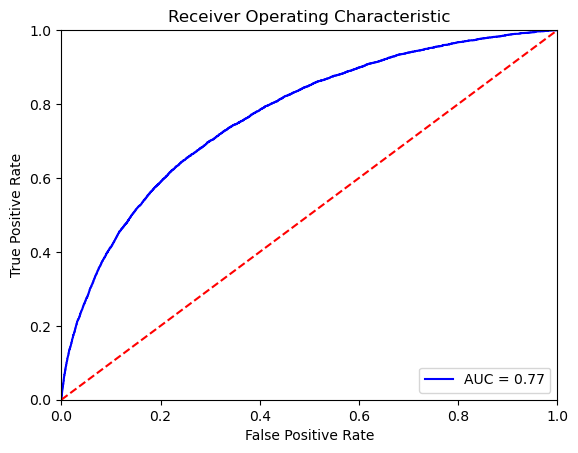

In [27]:
light_under = LGBMClassifier()
light_under.fit(X_under, y_under)

light_under_rus = light_under.predict(X_val_stand)

model_eval(light_under, X_val_stand, y_val)

L'utilisation de cette méthode de traitement du déséquilibre présente d'excellents résultats pour notre modélisation.
Nous constatons une forte amélioration de ce traitement.

Les modèles de Régression Logistique, du XGBoost et du LightGBM présentent de bons résultats.

Nous allons poursuivre notre méthode avec la méthode du RandomOverSample.

# 

### 2. RandomOverSample

In [28]:
over = RandomOverSampler(random_state=100)

# fit and apply the transform
X_over, y_over = over.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_over))

Counter({0: 211920, 1: 18709})
Counter({0: 211920, 1: 211920})


####  Régression Logistique

2023/06/09 18:17:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '49e80a927c434a2faf12768a57fe4f6a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[49657 21105]
 [ 1980  4135]]
Accuracy score    : 0.7
precision score   : 0.164
recall score      : 0.676
F1 score          : 0.264
F2 score          : 0.42
ROCAUC score      : 0.689
custom metric FMI : 0.333



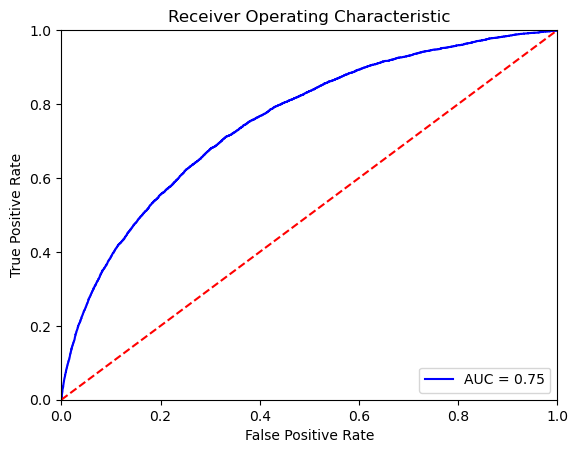

In [29]:
logis_over = LogisticRegression()
logis_over.fit(X_over, y_over)

reglog_under_ros = logis_over.predict(X_val_stand)

model_eval(logis_over, X_val_stand, y_val)

#### Dummy Classifier

2023/06/09 18:17:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '262775ba4474409786eac2400e12e249', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35295 35467]
 [ 3034  3081]]
Accuracy score    : 0.499
precision score   : 0.0799
recall score      : 0.504
F1 score          : 0.138
F2 score          : 0.24
ROCAUC score      : 0.501
custom metric FMI : 0.201



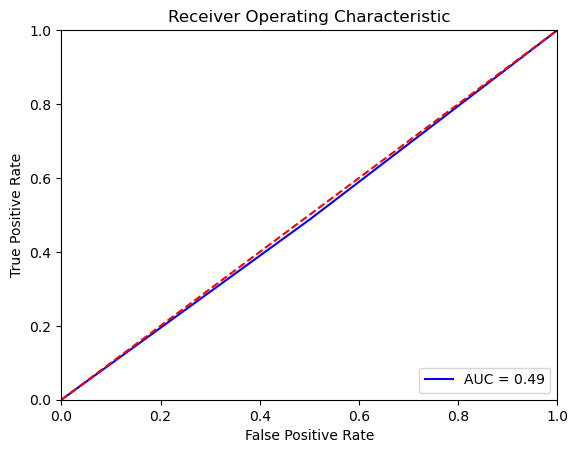

In [30]:
dummy_over = DummyClassifier(strategy="stratified")
dummy_over.fit(X_over, y_over)

dummy_under_ros = dummy_over.predict(X_val_stand)

model_eval(dummy_over, X_val_stand, y_val)

#### Random Forest

2023/06/09 18:17:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df54b1adb3d04f8b83ad075ab49690dd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[70664    98]
 [ 6031    84]]
Accuracy score    : 0.92
precision score   : 0.462
recall score      : 0.0137
F1 score          : 0.0267
F2 score          : 0.017
ROCAUC score      : 0.506
custom metric FMI : 0.0796



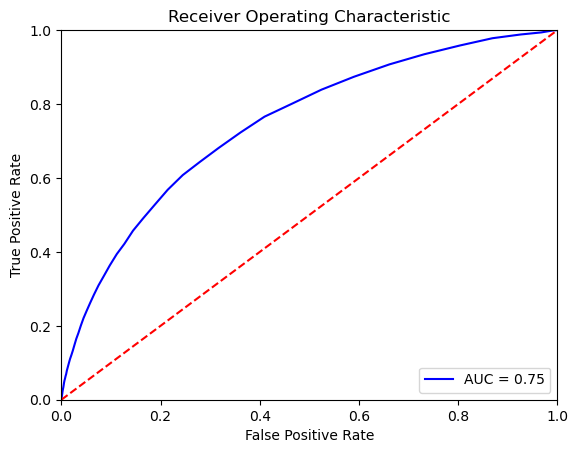

In [31]:
random_over = RandomForestClassifier()
random_over.fit(X_over, y_over)

random_under_ros = random_over.predict(X_val_stand)

model_eval(random_over, X_val_stand, y_val)

#### XGBoost

[[54747 16015]
 [ 2366  3749]]
Accuracy score    : 0.761
precision score   : 0.19
recall score      : 0.613
F1 score          : 0.29
F2 score          : 0.42
ROCAUC score      : 0.693
custom metric FMI : 0.341



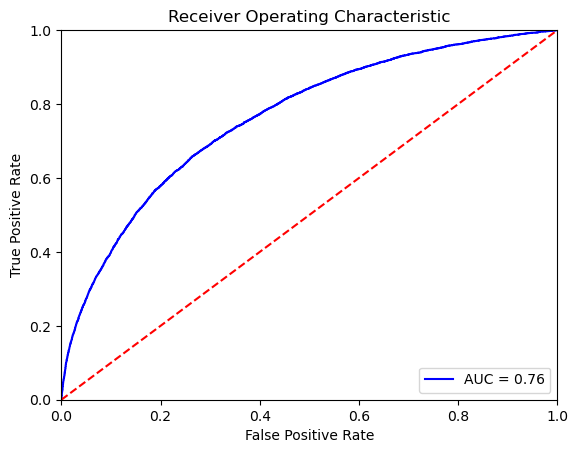

In [32]:
xgboost_over = xgb.XGBClassifier()
xgboost_over.fit(X_over, y_over)

xgboost_under_ros = xgboost_over.predict(X_val_stand)

model_eval(xgboost_over, X_val_stand, y_val)

#### LIGHTGBM

[[52051 18711]
 [ 1993  4122]]
Accuracy score    : 0.731
precision score   : 0.181
recall score      : 0.674
F1 score          : 0.285
F2 score          : 0.44
ROCAUC score      : 0.705
custom metric FMI : 0.349



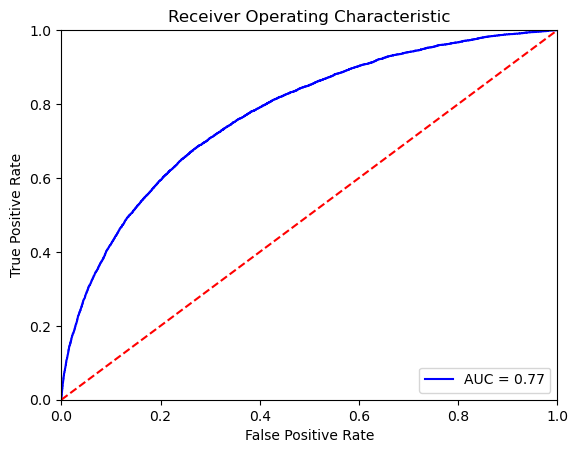

In [33]:
light_over = LGBMClassifier()
light_over.fit(X_over, y_over)

light_under_ros = light_over.predict(X_val_stand)

model_eval(light_over, X_val_stand, y_val)

Cette seconde méthode de traitement du déséquilibre présente une baisse de la qualité des résultats.
Toutefois, les modèles de Régression Logistique et le LightGBM présente de bons résultats.
Le XGBoost diminue assez fortement avec cette méthode.

Nous n'allons pas conserver cette technique de traitement.

Afin de finaliser notre sélection, nous allons procéder à l'utilisation de la méthode SMOTE.

# 

### 3. SMOTE

In [34]:
smote = SMOTE(random_state=100)

# fit and apply the transform
X_smote, y_smote = smote.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_smote))

2023/06/09 18:25:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '05934992e0774bc39e0c657f55082db4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:25:45 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/06/09 18:25:45 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/06/09 18:25:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Counter({0: 211920, 1: 18709})
Counter({0: 211920, 1: 211920})


#### Régression Logistique

2023/06/09 18:25:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0ec48c4489b243deb3233e3d3edb8a17', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[49816 20946]
 [ 2083  4032]]
Accuracy score    : 0.7
precision score   : 0.161
recall score      : 0.659
F1 score          : 0.259
F2 score          : 0.41
ROCAUC score      : 0.682
custom metric FMI : 0.326



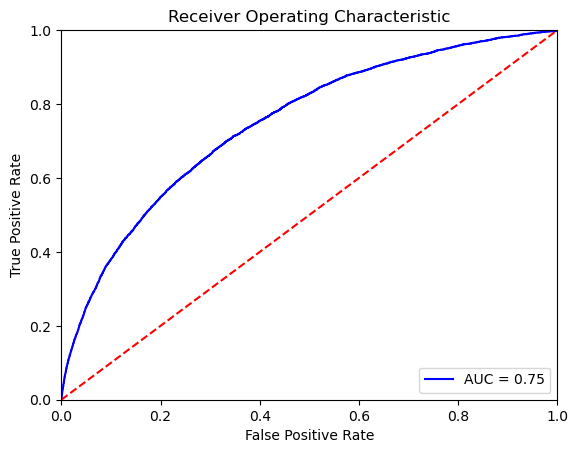

In [35]:

logis_smote = LogisticRegression()
logis_smote.fit(X_smote, y_smote)

reglog_under_smote = logis_smote.predict(X_val_stand)

model_eval(logis_smote, X_val_stand, y_val)

#### Dummy Classifier

2023/06/09 18:26:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '05cf6ee832f94eabbd2605ab05a9f4b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35404 35358]
 [ 3025  3090]]
Accuracy score    : 0.501
precision score   : 0.0804
recall score      : 0.505
F1 score          : 0.139
F2 score          : 0.25
ROCAUC score      : 0.503
custom metric FMI : 0.202



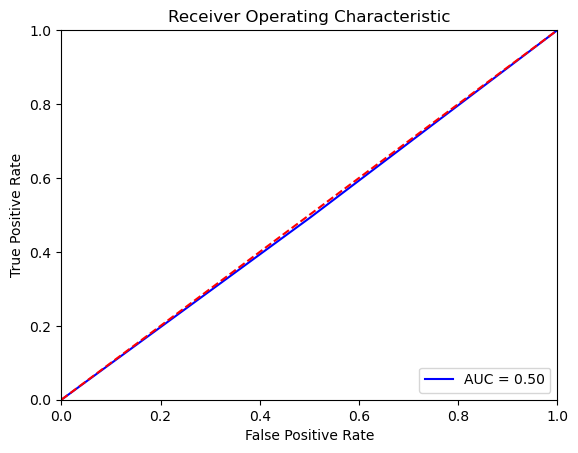

In [36]:
dummy_smote = DummyClassifier(strategy="stratified")
dummy_smote.fit(X_smote, y_smote)

dummy_under_smote = dummy_smote.predict(X_val_stand)

model_eval(dummy_smote, X_val_stand, y_val)

#### Random Forest

2023/06/09 18:26:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd33efc6e45bc4cad85d7e45fe153a0c5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[70001   761]
 [ 5802   313]]
Accuracy score    : 0.915
precision score   : 0.291
recall score      : 0.0512
F1 score          : 0.0871
F2 score          : 0.061
ROCAUC score      : 0.52
custom metric FMI : 0.122



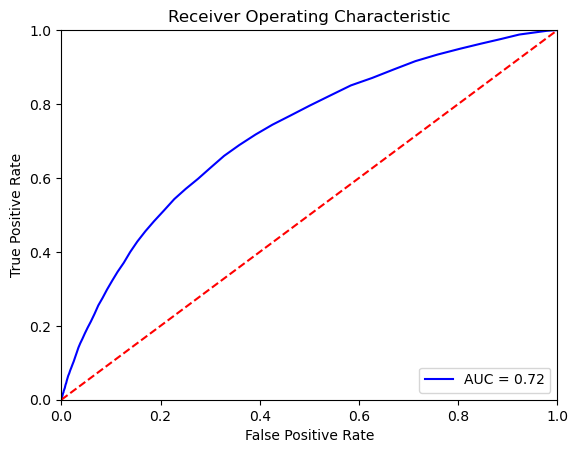

In [37]:
random_smote = RandomForestClassifier()
random_smote.fit(X_smote, y_smote)

random_under_smote = random_smote.predict(X_val_stand)

model_eval(random_smote, X_val_stand, y_val)

#### XGBoost

[[70078   684]
 [ 5633   482]]
Accuracy score    : 0.918
precision score   : 0.413
recall score      : 0.0788
F1 score          : 0.132
F2 score          : 0.094
ROCAUC score      : 0.535
custom metric FMI : 0.181



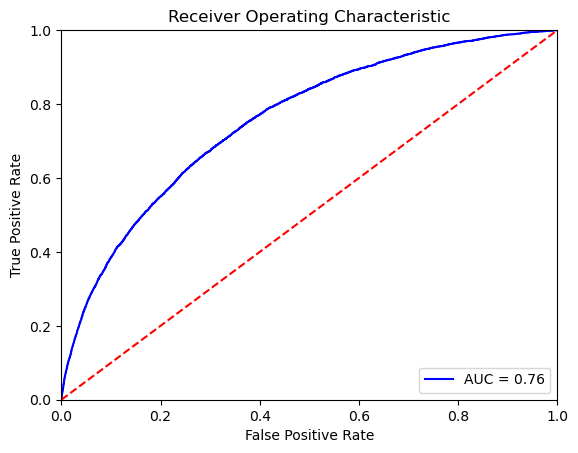

In [38]:
xgboost_smote = xgb.XGBClassifier()
xgboost_smote.fit(X_smote, y_smote)

xgboost_under_smote = xgboost_smote.predict(X_val_stand)

model_eval(xgboost_smote, X_val_stand, y_val)

#### LIGHTGBM

[[70253   509]
 [ 5822   293]]
Accuracy score    : 0.918
precision score   : 0.365
recall score      : 0.0479
F1 score          : 0.0847
F2 score          : 0.058
ROCAUC score      : 0.52
custom metric FMI : 0.132



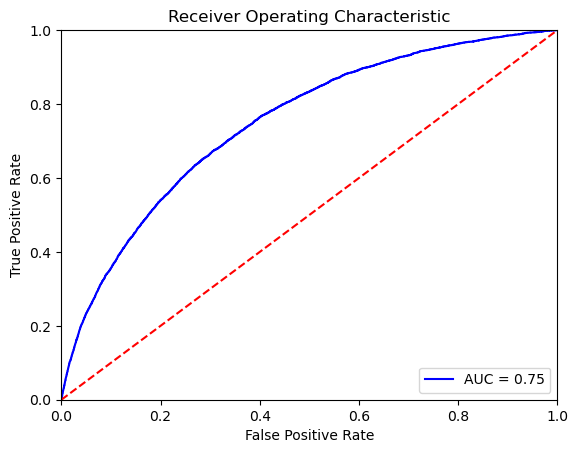

In [39]:
light_smote = LGBMClassifier()
light_smote.fit(X_smote, y_smote)

light_under_smote = light_smote.predict(X_val_stand)

model_eval(light_smote, X_val_stand, y_val)

Ici, nous pouvons constater que les différents modèles présentent des résultats plus faibles.
Hormis la Régression Logistique qui conserve un bon résultat, l'ensemble des modèles présentent des résultats assez faible.

Nous allons prendre la décision de ne pas utiliser la méthode SMOTE.

# 

Nous avons pu tester 3 méthodes afin de procéder au traitement du déséquilibre de notre jeu de données.

La méthode du RandomUnderSample présente les meilleurs résultats.
De plus, cette méthode nous a permis de procéder à la sélection de 3 modèles avec des résultats proches, à savoir :
- Régression Logistique,
- XGBoost,
- LightGBM.

Nous allons, à présent, procéder à l'optimisation de ces 3 modèles afin de procéder puis tester ces derniers afin de conserver le meilleur modèle.

## III. Optimisation des modèles

### A. Optimisation de la Régression Logistique

#### Cross Validation

In [40]:
cross_val_score(LogisticRegression(), X_under, y_under, cv = 10).mean()

2023/06/09 18:38:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d91e8fcefad4e738354d061724e96fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:38:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b34d26adb2c34bdea3c4b7b02f31942e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:38:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4762c9a9368e471e96420ad8719f71fc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:38:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08823a9e33664f418979b1efde1cf098', which will track hyperparameters, performance metrics, model artifacts, and lineage i

0.6959749970390365

In [41]:
C = [1,10,100,1000, 10000, 100000]
score_apprentissage, score_validation = validation_curve(logis_under, X_under, y_under,
                                                        param_name = 'C',
                                                        param_range = C, cv = 10)

2023/06/09 18:39:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5b03a4a900c4a85a8ab47dc464a130a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:39:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '624d130960954eaaa97a003e5dc9e96a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:39:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65ccae78bb074f73b9abaf7ade0bec4c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:39:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '695a77f8d2c14aa493c5878847256445', which will track hyperparameters, performance metrics, model artifacts, and lineage i

In [42]:
score_validation.mean(axis = 1)

array([0.695975  , 0.69594827, 0.69605518, 0.69592156, 0.69600171,
       0.69597499])

In [43]:
plt.plot(C, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(C, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

#### GridSearch CV

In [44]:
grid_param = {'C' : [0, 5000, 10000],
             'random_state' : [100, 1000, 2000, 10000]}
              
grid_search_rl = GridSearchCV(LogisticRegression(), grid_param, cv = 5)

In [45]:
# ici, on entraine la fonction
grid_search_rl.fit(X_under, y_under)

2023/06/09 18:43:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9fac82896fdf4944a5682f2d20de4804', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 18:43:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0, 5000, 10000],
                         'random_state': [100, 1000, 2000, 10000]})

In [46]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_rl.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_rl.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.696322382042089
Les meilleurs hyperparamètres sont :  {'C': 10000, 'random_state': 100}


### A. Optimisation du XGBOOST

#### Cross Validation

In [47]:
cross_val_score(xgb.XGBClassifier(), X_under, y_under, cv = 10).mean()

0.6960289658658422

###### Paramètre Max_Depth

In [48]:
%%time


max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
score_apprentissage, score_validation = validation_curve(xgboost_under, X_under, y_under,
                                                          param_name='max_depth',
                                                          param_range=max_depth, cv=10)

t=2023-06-09T19:16:25-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=9d2f1ba929b5 clientid=705443643a72d1b3ca35ad12cfbf05d1
t=2023-06-09T19:16:25-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=2dd7b297a630 err="read EOF from remote peer"
t=2023-06-09T19:25:01-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=b983bd79e183 clientid=705443643a72d1b3ca35ad12cfbf05d1
t=2023-06-09T19:25:01-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=2dd7b297a630 err="session closed"
t=2023-06-09T19:25:11-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp [2600:1f16:d83:1202::6e74:2]:443: i/o timeout"
t=2023-06-09T19:25:22-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp [2600:1f16:d83:1202::6e74:2]:443: i/o timeout"
t=2023-06-09T19:25:32-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp 3.136.132

CPU times: total: 4h 9min 25s
Wall time: 41min 2s


In [49]:
score_validation.mean(axis = 1)

array([0.70693239, 0.70567616, 0.69602897, 0.69001561, 0.68908045,
       0.6918062 , 0.69250097, 0.69503987, 0.69234089, 0.69544071])

In [50]:
plt.plot(max_depth, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(max_depth, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

###### Learning Rate

In [51]:
%%time

learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
score_apprentissage, score_validation = validation_curve(xgboost_under, X_under, y_under,
                                                          param_name='learning_rate',
                                                          param_range=learning_rate, cv=10)

t=2023-06-09T19:36:33-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=8d4cb3433cb7 clientid=705443643a72d1b3ca35ad12cfbf05d1
t=2023-06-09T19:36:33-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=2dd7b297a630 err="session closed"
t=2023-06-09T19:36:43-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp [2600:1f16:d83:1202::6e74:2]:443: i/o timeout"
t=2023-06-09T19:36:54-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp [2600:1f16:d83:1202::6e74:2]:443: i/o timeout"
t=2023-06-09T19:37:05-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="dial tcp 3.136.132.147:443: i/o timeout"
t=2023-06-09T19:37:16-0400 lvl=eror msg="failed to reconnect session" obj=csess id=2dd7b297a630 err="Get \"https://s3.amazonaws.com/dns.ngrok.com/tunnel.json\": context deadline exceeded"
t=2023-06-09T19:37:17-0400 lvl=eror msg="failed to reconnect session" obj=cses

CPU times: total: 1h 38min 9s
Wall time: 15min 12s


In [52]:
score_validation.mean(axis = 1)

array([0.67833673, 0.70567655, 0.70637131, 0.7038589 , 0.69041637,
       0.66943726, 0.65545982])

In [53]:
plt.plot(learning_rate, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(learning_rate, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

#### GridSearchCV

In [54]:
grid_param = {'max_depth': [2, 3, 4],
             'learning_rate': [0.1, 0.15]}
              
grid_search_xg = GridSearchCV(xgb.XGBClassifier(), grid_param, cv = 5, verbose = 5)

In [55]:
%%time

# ici, on entraine la fonction
grid_search_xg.fit(X_train_stand, y_train)

2023/06/09 19:41:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '065d83af058f4b2db92933b7fd72fc08', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/09 19:41:09 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
             ...`


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....learning_rate=0.1, max_depth=2;, score=0.919 total time=  22.5s
[CV 2/5] END ....learning_rate=0.1, max_depth=2;, score=0.919 total time=  21.6s
[CV 3/5] END ....learning_rate=0.1, max_depth=2;, score=0.919 total time=  21.9s
[CV 4/5] END ....learning_rate=0.1, max_depth=2;, score=0.919 total time=  22.2s
[CV 5/5] END ....learning_rate=0.1, max_depth=2;, score=0.919 total time=  22.9s
[CV 1/5] END ....learning_rate=0.1, max_depth=3;, score=0.919 total time=  32.0s
[CV 2/5] END ....learning_rate=0.1, max_depth=3;, score=0.919 total time=  32.7s
[CV 3/5] END ....learning_rate=0.1, max_depth=3;, score=0.919 total time=  31.7s
[CV 4/5] END ....learning_rate=0.1, max_depth=3;, score=0.919 total time=  31.3s
[CV 5/5] END ....learning_rate=0.1, max_depth=3;, score=0.919 total time=  31.2s
[CV 1/5] END ....learning_rate=0.1, max_depth=4;, score=0.919 total time=  41.4s
[CV 2/5] END ....learning_rate=0.1, max_depth=4;,

2023/06/09 19:58:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


CPU times: total: 1h 51min 27s
Wall time: 17min 2s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [2, 3, 4]},
             verbose=5)

In [56]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_xg.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_xg.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.919142864643059
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.1, 'max_depth': 4}


# 

### A. Optimisation du LightGBM

#### Cross Validation

In [57]:
cross_val_score(LGBMClassifier(), X_under, y_under, cv = 10).mean()

0.7083222431144562

###### Paramètre Max_depth

In [58]:
%%time


max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
score_apprentissage, score_validation = validation_curve(light_under, X_under, y_under,
                                                          param_name='max_depth',
                                                          param_range=max_depth, cv=10)

CPU times: total: 15min 36s
Wall time: 2min 29s


In [59]:
score_validation.mean(axis = 1)

array([0.69680378, 0.70637124, 0.70882987, 0.70883021, 0.70984557,
       0.70877642, 0.70792125, 0.70770766, 0.70853609, 0.70832224])

In [60]:
plt.plot(max_depth, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(max_depth, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

###### Learning Rate

In [61]:
%%time

learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
score_apprentissage, score_validation = validation_curve(light_under, X_under, y_under,
                                                          param_name='learning_rate',
                                                          param_range=learning_rate, cv=10)

CPU times: total: 11min 29s
Wall time: 1min 48s


In [62]:
score_validation.mean(axis = 1)

array([0.68090247, 0.70685238, 0.70832224, 0.7038589 , 0.67830942,
       0.66468018, 0.6505423 ])

In [63]:
plt.plot(learning_rate, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(learning_rate, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

Pour le LearningRate, nous constatons de suite que le meilleur résultat est de 0.5, nous testerons entre 0.4 et 0.6 pour notre dernière étape.

#### GridSearch CV

In [64]:
%%time

grid_param = {'max_depth': [8, 10,12, 14, 16, 18],
             'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}
              
grid_search_light = GridSearchCV(LGBMClassifier(), grid_param, cv = 5, verbose = 5)

CPU times: total: 0 ns
Wall time: 0 ns


In [65]:
%%time

# ici, on entraine la fonction
grid_search_light.fit(X_under, y_under)

2023/06/09 20:02:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '43f4530f7d0d4b1da6264ccaf7eb9c05', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ....learning_rate=0.1, max_depth=8;, score=0.710 total time=   1.2s
[CV 2/5] END ....learning_rate=0.1, max_depth=8;, score=0.710 total time=   1.2s
[CV 3/5] END ....learning_rate=0.1, max_depth=8;, score=0.710 total time=   1.4s
[CV 4/5] END ....learning_rate=0.1, max_depth=8;, score=0.708 total time=   2.0s
[CV 5/5] END ....learning_rate=0.1, max_depth=8;, score=0.707 total time=   1.2s
[CV 1/5] END ...learning_rate=0.1, max_depth=10;, score=0.709 total time=   1.2s
[CV 2/5] END ...learning_rate=0.1, max_depth=10;, score=0.714 total time=   1.2s
[CV 3/5] END ...learning_rate=0.1, max_depth=10;, score=0.707 total time=   1.2s
[CV 4/5] END ...learning_rate=0.1, max_depth=10;, score=0.709 total time=   1.2s
[CV 5/5] END ...learning_rate=0.1, max_depth=10;, score=0.712 total time=   1.2s
[CV 1/5] END ...learning_rate=0.1, max_depth=12;, score=0.709 total time=   1.3s
[CV 2/5] END ...learning_rate=0.1, max_depth=12

2023/06/09 20:06:04 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.


CPU times: total: 20min 5s
Wall time: 3min 20s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [8, 10, 12, 14, 16, 18]},
             verbose=5)

In [66]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_light.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_light.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.7102196976963926
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.1, 'max_depth': 10}


# 

### D. Entrainement des modèles optimisés

#### Préparation des données

In [67]:
# Création des déséquilibres

under = RandomUnderSampler(random_state=100)

# fit and apply the transform
X_under, y_under = under.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 211920, 1: 18709})
Counter({0: 18709, 1: 18709})


##### LIGHTGBM

[[50141 20621]
 [ 1858  4257]]
Accuracy score    : 0.708
precision score   : 0.171
recall score      : 0.696
F1 score          : 0.275
F2 score          : 0.43
ROCAUC score      : 0.702
custom metric FMI : 0.345



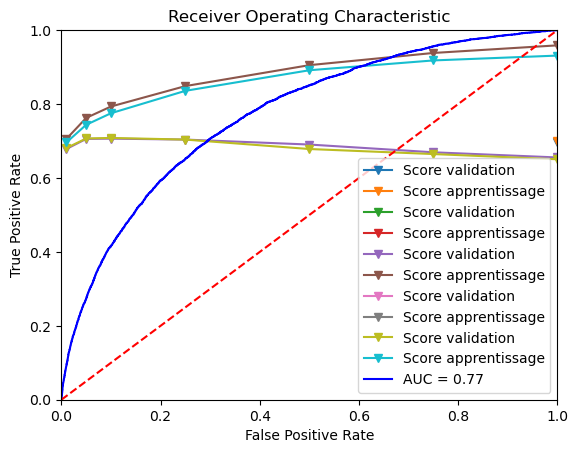

In [68]:
# Entrainement avec nos meilleurs paramètres
params = {'learning_rate': 0.1,
          'max_depth': 10}


lightgbm = LGBMClassifier(**params)

# Entrainement avec LIGHTGBM
model = lightgbm.fit(X_under, y_under)

y_pred_rus = lightgbm.predict(X_val_stand)

model_eval(lightgbm, X_val_stand, y_val)

##### XGBoost

[[49924 20838]
 [ 1871  4244]]
Accuracy score    : 0.705
precision score   : 0.169
recall score      : 0.694
F1 score          : 0.272
F2 score          : 0.43
ROCAUC score      : 0.7
custom metric FMI : 0.343



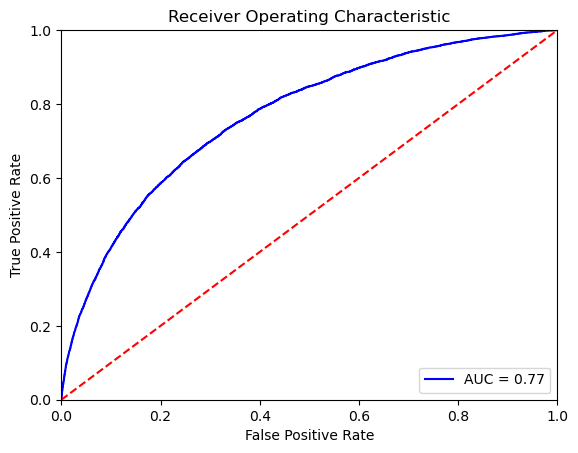

In [69]:
# Entrainement avec nos meilleurs paramètres
param_xgboost = {'learning_rate': 0.15,
          'max_depth': 4}

xgboost =xgb.XGBClassifier(**param_xgboost)

# Entrainement avec LIGHTGBM
model2 = xgboost.fit(X_under, y_under)

y_pred_rus = xgboost.predict(X_val_stand)

model_eval(xgboost, X_val_stand, y_val)

##### Régression Logistique

2023/06/09 20:06:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3d1f5b0130d148c0a7eca8006421d40e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[49294 21468]
 [ 1959  4156]]
Accuracy score    : 0.695
precision score   : 0.162
recall score      : 0.68
F1 score          : 0.262
F2 score          : 0.41
ROCAUC score      : 0.688
custom metric FMI : 0.332



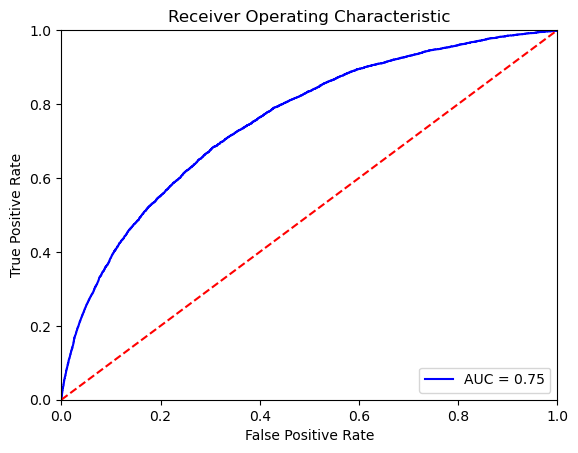

In [70]:
# Entrainement avec nos meilleurs paramètres
param_log = {'C': 10000,
          'random_state': 100}

reg_log = LogisticRegression(**param_log)

# Entrainement avec LIGHTGBM
model3 = reg_log.fit(X_under, y_under)

y_pred_rus = reg_log.predict(X_val_stand)

model_eval(reg_log, X_val_stand, y_val)

Notre accuracy a légèrement diminué mais nous constatons une très forte amélioration de notre F2 score.
Nous pouvons estimer que notre étape de modélisation est désormais cohérente.

Nous allons sauvegarder ce modèle afin de pouvoir travailler sur notre phase de déploiement de ce modèle.

### E. Enregistrement du modèle

In [71]:
import pickle

# Sauvegarde du modèle
with open('model_streamlit.pkl', 'wb') as file:
    pickle.dump(model, file)

# 

## IV. Conclusion partie modélisation

En conclusion, dans notre projet, nous avons utilisé le fichier que nous avons créé lors de la première étape, comprenant l'exploration des données et le feature engineering, comme point de départ pour la modélisation. Pour standardiser les données, nous avons comparé les techniques de MinMaxScaler et StandardScaler, et avons sélectionné la meilleure méthode en fonction de nos besoins spécifiques.

Afin de conserver un enregistrement de tous nos modèles, nous avons utilisé MLFLOW, une bibliothèque qui nous permet de suivre, gérer et comparer les performances de nos modèles de manière efficace.

Au cours de l'entraînement de nos modèles, nous avons été confrontés à la difficulté du déséquilibre des données, un défi courant dans de nombreux problèmes de classification. Pour gérer ce déséquilibre, nous avons exploré différentes techniques, parmi lesquelles le RandomUnderSample s'est révélé être le modèle le plus performant.

Ensuite, nous avons procédé à l'optimisation des meilleurs modèles sélectionnés, puis à leur entraînement approfondi afin de déterminer le meilleur modèle pour notre tâche spécifique. Finalement, le LightGBM s'est avéré être le modèle qui traite le mieux le déséquilibre des données, offrant ainsi des résultats plus précis et fiables.

Dans l'ensemble, notre projet a été caractérisé par une approche itérative et méthodique, en utilisant différentes techniques pour relever les défis spécifiques liés aux données déséquilibrées. Les résultats obtenus grâce à l'utilisation de MLFLOW, la sélection du meilleur modèle et l'optimisation des performances nous ont permis de faire face à ces difficultés et d'obtenir un modèle performant pour notre tâche de classification.

# 

In [ ]:
# Cellule pour permettre lien avec MLFLOW
!mlflow ui

t=2023-06-09T20:52:04-0400 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=0e206b42dac4 clientid=705443643a72d1b3ca35ad12cfbf05d1
t=2023-06-09T20:52:04-0400 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=2dd7b297a630 err="session closed"
